# Create Note Embeddings

### Import Modules

In [1]:
import os
import re

import h5py
import nltk
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

tqdm.pandas()

## Load & Prepare ICU Stays Dataset

In [2]:
df_icustays = pd.read_csv('../data/original/ICUSTAYS.csv')
df_icustays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


Format time column and create a date column.

In [3]:
df_icustays.INTIME = df_icustays.INTIME.astype('datetime64[ns]')
df_icustays.OUTTIME = df_icustays.OUTTIME.astype('datetime64[ns]')

df_icustays['INDATE'] = df_icustays.INTIME.dt.date.astype('datetime64[ns]')
df_icustays['OUTDATE'] = df_icustays.OUTTIME.dt.date.astype('datetime64[ns]')

Filter out unecessary data.
1. For each patient only their first ICU stay is kept (all hospital admissions besides the first are ignored).
2. Remove uneccsary columns.
3. Remove entries that are missing an in or out time.

In [4]:
df_icustays = df_icustays.sort_values(by='INTIME').groupby(['SUBJECT_ID']).first()
df_icustays = df_icustays[["HADM_ID","ICUSTAY_ID","INTIME","INDATE","OUTTIME","OUTDATE"]]

# Impossible to verify notes belonging to an ICU stay without a time or date
df_icustays.dropna(subset=['INTIME','OUTTIME','INDATE','OUTDATE'], inplace=True)

Format index to match with the `multi_to_patid` dataset.

In [5]:
df_icustays.reset_index(inplace=True)
df_icustays.set_index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'], inplace=True)

## Load & Prepare Notes Dataset

In [6]:
df_notes = pd.read_csv('../data/original/NOTEEVENTS.csv', low_memory=False)
df_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB


*Filtering*:
1. Keep only the most relevant columns.
2. Remove rows with no text records.

In [7]:
df_notes = df_notes[['SUBJECT_ID','HADM_ID','CHARTDATE','CHARTTIME','CATEGORY','TEXT']]
df_notes.dropna(subset=['TEXT'], inplace=True)
df_notes.drop_duplicates(subset=['TEXT'], inplace=True)
df_notes.head()

,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,CATEGORY,TEXT
0,22532,167853.0,2151-08-04,NaN,Discharge summary,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,2118-06-14,NaN,Discharge summary,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,2119-05-25,NaN,Discharge summary,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,2124-08-18,NaN,Discharge summary,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,2162-03-25,NaN,Discharge summary,Admission Date: [**2162-3-3**] D...


Remove spaces from category labels

In [8]:
for category in df_notes.CATEGORY.unique():
    if len(category.strip()) != len(category):
        df_notes.loc[df_notes.CATEGORY == category, 'CATEGORY'] = category.strip()

Cast chart date and time columns to `datetime`

In [9]:
df_notes.CHARTDATE = df_notes.CHARTDATE.astype('datetime64[ns]')
df_notes.CHARTTIME = df_notes.CHARTTIME.astype('datetime64[ns]')

Setup index to mirror `multi_to_patid`

In [10]:
df_notes.set_index(['SUBJECT_ID','HADM_ID'], inplace=True)

## Match up notes with ICUStays

Merge ICU information with notes

In [11]:
df_notes_icu = df_icustays.copy()
df_notes_icu = df_notes_icu.join(df_notes, how='inner')

Remove all records that aren't for the first ICU stay. The ICU stays dataframe only contains the first icu stay for each patient, so we just need to verify that the charted time/date of the note is within the time bounds of the matched ICU stay.

In [12]:
date_val = (df_notes_icu.CHARTDATE >= df_notes_icu.INDATE) & (df_notes_icu.CHARTDATE <= df_notes_icu.OUTDATE)
time_val = (df_notes_icu.CHARTTIME >= df_notes_icu.INTIME) & (df_notes_icu.CHARTTIME <= df_notes_icu.OUTTIME)
datetime_val = (df_notes_icu.CHARTTIME.isna() & date_val) | (~df_notes_icu.CHARTTIME.isna() & time_val)

df_notes_icu = df_notes_icu.loc[datetime_val]

In [13]:
del df_notes

## Replace index with patient ID

In [14]:
multi_to_patid = pd.read_csv('../data/processed/multi_to_patid.csv')
multi_to_patid.head()

,subject_id,hadm_id,icustay_id,pat_id
0,3,145834,211552,0
1,4,185777,294638,1
2,6,107064,228232,2
3,9,150750,220597,3
4,11,194540,229441,4


In [15]:
multi_to_patid.set_index(['subject_id','hadm_id','icustay_id'], inplace=True)
df_notes_icu.index.names = ['subject_id','hadm_id','icustay_id']
df_notes_icu = multi_to_patid.join(df_notes_icu, how='left')
df_notes_icu.set_index('pat_id', inplace=True)

Some rows get null time/dates after the swap (less than a thousand).

In [16]:
df_notes_icu.dropna(subset=['INTIME','OUTTIME','INDATE','OUTDATE'], inplace=True)

## Split Static (Discharge) from Time-Series Notes

In [17]:
df_static_notes = df_notes_icu.loc[df_notes_icu.CATEGORY == 'Discharge summary', :].copy()
df_ts_notes = df_notes_icu.loc[~(df_notes_icu.CATEGORY == 'Discharge summary'), :].copy()
del df_notes_icu

## Clean up Static Notes

In [18]:
STATIC_SEP_TOKEN = 'STATIC_SEP'
df_static_notes = df_static_notes.groupby('pat_id').TEXT.agg(lambda txts: f" {STATIC_SEP_TOKEN} ".join(txts))

## Clean up Time-Series Notes

Impute a `CHARTTIME` for `ECG` and `Echo` text records.
1. If `CHARTDATE` is `INDATE` -> `INTIME`
2. IF `CHARTDATE` is not `INDATE` or `ENDATE` -> `INTIME`
3. IF `CHARTDATE` is `ENDDATE` -> `min(INTIME, OUTTIME)`

Note the date will still be `CHARTDATE`, we're only using the time portion of the `INTIME` and `OUTTIME` values.

In [19]:
def impute_charttime(row: pd.Series) -> pd.Timestamp:
    if row.CHARTDATE != row.OUTDATE:
        charttime = row.INTIME.time()
    else:
        charttime = min(row.INTIME.time(), row.OUTTIME.time())
    return pd.Timestamp.combine(row.CHARTDATE.date(), charttime)

df_ts_notes.loc[df_ts_notes.CHARTTIME.isna(), 'CHARTTIME'] = df_ts_notes.loc[df_ts_notes.CHARTTIME.isna()].apply(impute_charttime, axis=1)

Create the `HOURS_IN` column and add it to the index.
Then remove all of the unecessary time and date information.

In [20]:
df_ts_notes['hours_in'] = (df_ts_notes.CHARTTIME - df_ts_notes.INTIME) // pd.Timedelta(hours=1)
df_ts_notes = df_ts_notes.reset_index().set_index(['pat_id','hours_in'])
df_ts_notes = df_ts_notes[['CATEGORY','TEXT']]

## Find the ideal limit for `HOURS_IN`

Find each patients max for `HOURS_IN`

In [21]:
max_hi = {}
for pat_id, hours_in in df_ts_notes.index:
    max_hi[pat_id] = hours_in if pat_id not in max_hi else max(max_hi[pat_id], hours_in)
max_hi = np.array(list(max_hi.values()))

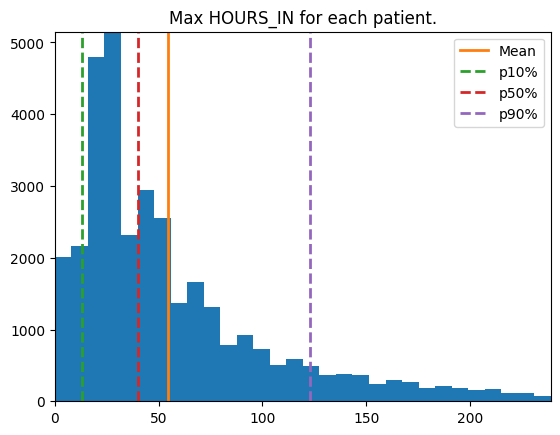

Mean: 54.578
10% Percentile: 13.000
50% Percentile: 40.000
90% Percentile: 123.000


In [22]:
percentiles = [10, 50, 90]
max_mean, max_percs = max_hi.mean(), [np.percentile(max_hi, p) for p in percentiles]

# Plot histogram
bin_vals, _, _ = plt.hist(max_hi, bins=30)
x_top, y_top = max(max_hi), max(bin_vals)
plt.xlim([0,x_top])
plt.ylim([0,y_top])

# Plot mean and percentile lines.
plt.plot([max_mean, max_mean],[0, y_top], label='Mean', linewidth=2)
for dist_perc, perc in zip(max_percs, percentiles):
    plt.plot([dist_perc, dist_perc],[0,y_top], '--', label='p%d%%' % perc, linewidth=2)

plt.title("Max HOURS_IN for each patient.")
plt.legend()
plt.show()

print("Mean: %.3f" % max_mean)
for dist_perc, perc in zip(max_percs, percentiles):
    print("%d%% Percentile: %.3f" % (perc, dist_perc))

In [23]:
HOURS_IN_MAX = 128
df_ts_notes = df_ts_notes.loc[df_ts_notes.index.get_level_values(1) < HOURS_IN_MAX]

## Save Categories

In [26]:
cat2ohe = {cat: idx for idx, cat in enumerate(df_ts_notes.CATEGORY.unique())}

## Clean Text

In [28]:
def clean_text(txt: str):
    # Remove dates and subtext
    clean = re.sub(" ?\[\*\*[^\*]*\*\*\] ?", '', txt)
    # Remove newlines
    clean = re.sub('\n', ' ', clean)
    # Remove multiple consecutive spaces
    clean = re.sub('  *', ' ', clean)
    # Remove horizontal lines
    clean = re.sub('_{2,}', '', clean)
    return clean

In [29]:
df_static_notes = df_static_notes.progress_map(clean_text)
df_ts_notes.TEXT = df_ts_notes.TEXT.progress_map(clean_text)

100%|██████████| 430550/430550 [00:23<00:00, 18338.61it/s]


In [30]:
df_ts_notes = df_ts_notes.groupby(['pat_id', 'hours_in']).agg(lambda txts: " [SEP] ".join(txts))

## Split Notes by Train and Test

In [31]:
processed_dir = '../data/processed/'
train_idxs = set(np.load(os.path.join(processed_dir, 'train_idxs.npy')))
test_idxs = set(np.load(os.path.join(processed_dir, 'test_idxs.npy')))

static_idxs = set(df_static_notes.index.values)
ts_idxs = set(df_ts_notes.index.get_level_values(0).values)

train_idxs_static = list(static_idxs & train_idxs)
test_idxs_static = list(static_idxs & test_idxs)

train_idxs_ts = list(ts_idxs & train_idxs)
test_idxs_ts = list(ts_idxs & test_idxs)

In [32]:
df_static_train = df_static_notes.loc[train_idxs_static].copy()
df_static_test = df_static_notes.loc[test_idxs_static].copy()
df_ts_train = df_ts_notes.loc[train_idxs_ts].copy()
df_ts_test = df_ts_notes.loc[test_idxs_ts].copy()

In [33]:
del df_static_notes
del df_ts_notes

## Create Embeddings with BERT

In [34]:
from transformers import BertTokenizer, BertModel
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained("bert-base-uncased").to(device)

c:\Users\Jason\Work\M3Care\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [35]:
for param in bert.parameters():
    param.requires_grad = False

bert.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [36]:
from typing import Literal
from torch import Tensor
import torch
import math

def window_split(tokens: list[int], max_len: int = 512, cls_tok_id: int = 101, sep_tok_id: int = 102) -> Tensor:
    num_toks = len(tokens)
    tokens = torch.tensor(tokens, dtype=torch.int64, device=device)

    if num_toks <= max_len:
        padded = torch.zeros(1, max_len, dtype=torch.int64, device=device)
        att_mask = torch.zeros_like(padded)
        padded[0, :num_toks], att_mask[0, :num_toks] = tokens, 1
        return padded, att_mask

    window_size = max_len - 2
    num_windows = math.ceil((num_toks - 2) / (window_size))

    windows = torch.zeros(num_windows, max_len, dtype=torch.int64, device=device)
    windows[:, 0] = cls_tok_id
    windows[:, -1] = sep_tok_id

    for widx in range(num_windows):
        st_idx = 1 + (widx * window_size)
        ed_idx = st_idx + window_size
        
        if ed_idx >= num_toks:
            shift = ed_idx - num_toks + 1
            st_idx, ed_idx = st_idx-shift, ed_idx-shift
        windows[widx, 1:-1] = tokens[st_idx:ed_idx]

    att_mask = torch.ones_like(windows)

    return windows, att_mask


def tokenize(texts: pd.Series, max_len=512):
    texts = texts.tolist()
    tokens = tokenizer(texts)['input_ids']
    
    windows, att_masks, win_cnts = [], [], []
    for toks in tokens:
        win_splits, att_mask = window_split(toks, max_len=max_len)
        windows.append(win_splits)
        att_masks.append(att_mask)
        win_cnts.append(win_splits.shape[0])

    windows = torch.concat(windows, dim=0)
    att_masks = torch.concat(att_masks, dim=0)
    win_cnts = torch.tensor(win_cnts, device=device)

    return windows, att_masks, win_cnts

def unify_windows(embeddings: Tensor, win_cnts: Tensor, method: Literal['mean'] | Literal['max'] = 'mean'):
    num_embed, embed_dim = len(win_cnts), embeddings.shape[1]

    unified = torch.zeros(num_embed, embed_dim, device=device)
    embed_to_unified = [i for i, v in enumerate(win_cnts) for _ in range(v)]

    for embed_idx, e2u in enumerate(embed_to_unified):
        if method == 'mean':
            unified[e2u] += embeddings[embed_idx]
        else:
            unified[e2u] = torch.max(unified[e2u], embeddings[embed_idx])

    if method == 'mean':
        unified /= win_cnts.unsqueeze(-1)

    return unified



In [37]:
from pathlib import Path

class H5FileManager(object):
    def __init__(self, path: str | Path):
        self.path = Path(path)

        if self.path.suffix != '.h5':
            raise ValueError("H5FileManager: Provided path must be to a `h5` file.")
        if not self.path.exists():
            with h5py.File(self.path, 'w') as _:
                self.groups = set()
        else:
            with h5py.File(self.path, 'r') as f:
                self.groups = set(f.keys())

    def save(self, group: str, dataset_name: str, data: Tensor):
        with h5py.File(self.path, 'a') as f:
            if group not in self.groups:
                f.create_group(group)
                self.groups.add(group)
            f[group].create_dataset(dataset_name, data=data)

    def agg_save(self, groups: list[str], dataset_names: list[str], data: Tensor):
        with h5py.File(self.path, 'a') as f:
            for group, dataset_name, datum in zip(groups, dataset_names, data):
                if group not in self.groups:
                    f.create_group(group)
                    self.groups.add(group)
                f[group].create_dataset(dataset_name, data=datum)

In [39]:
def ohe_categories(categories: pd.Series):
    num_cats = len(cat2ohe)

    ohe = torch.zeros(len(categories), num_cats, dtype=torch.int64).to(device)
    
    for eidx, entry in enumerate(categories):
        for cat in entry.split(' [SEP] '):
            ohe[eidx, cat2ohe[cat]] = 1

    return ohe

def embed_static(notes: pd.Series):
    windows, att_masks, win_cnts = tokenize(notes)
    with torch.no_grad():
        embeddings = bert(windows, att_masks).pooler_output
    embeddings = unify_windows(embeddings, win_cnts)

    return embeddings

def embed_ts(notes: pd.DataFrame):
    windows, att_masks, win_cnts = tokenize(notes.TEXT)
    with torch.no_grad():
        embeddings = bert(windows, att_masks).pooler_output
    embeddings = unify_windows(embeddings, win_cnts)

    ohe = ohe_categories(notes.CATEGORY)
    embeddings = torch.concat([embeddings, ohe], dim=1)

    return embeddings

In [44]:
def embed_and_save_static(s: pd.Series, batch_size: int, path: Path | str):
    num_samples = s.shape[0]
    num_batches = math.ceil(num_samples / batch_size)
    fm = H5FileManager(path)

    for bidx in tqdm(range(num_batches)):
        sub = s.iloc[(si := bidx*batch_size):(si+batch_size)]
        emb = embed_static(sub).cpu().numpy()
        groups = [f"pat_id_{pid}" for pid in sub.index]
        fm.agg_save(groups, 'discharge', emb)
        torch.cuda.empty_cache()

def embed_and_save_ts(df: pd.DataFrame, batch_size: int, path: Path | str):
    num_samples = df.shape[0]
    num_batches = math.ceil(num_samples / batch_size)
    fm = H5FileManager(path)

    for bidx in tqdm(range(num_batches)):
        sub = df.iloc[(si := bidx*batch_size):(si+batch_size)]
        emb = embed_ts(sub).cpu().numpy()
        groups = [f"pat_id_{pid}" for pid, _ in sub.index]
        times = [f"time_{tm}" for _, tm in sub.index]
        fm.agg_save(groups, times, emb)
        torch.cuda.empty_cache()

In [56]:
fm = embed_and_save_static(df_static_train, 32, '../data/processed/train/static_notes_bert.h5')

100%|██████████| 107/107 [05:09<00:00,  2.90s/it]


In [55]:
fm = embed_and_save_static(df_static_test, 32, '../data/processed/test/static_notes_bert.h5')

100%|██████████| 29/29 [01:15<00:00,  2.59s/it]


In [46]:
fm = embed_and_save_ts(df_ts_train, 32, '../data/processed/train/ts_notes_bert.h5')

100%|██████████| 7433/7433 [2:04:17<00:00,  1.00s/it]  


In [47]:
fm = embed_and_save_ts(df_ts_test, 32, '../data/processed/test/ts_notes_bert.h5')

100%|██████████| 1820/1820 [30:19<00:00,  1.00it/s]
